In [1]:
!nvidia-smi

Wed Feb  8 02:55:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P0    43W / 163W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [2]:
# install dependents
# !pip install -q monailabel-weekly
# !pip install -q monai
# !pip uninstall opencv-contrib-python -y
# !pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30
# !pip install -q timm
# !pip install -U -q openmim
# !mim install -U -q mmcv-full
# !pip install -q ml_collections

In [1]:
# mount driver
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH
# sync python module
%load_ext autoreload
%autoreload 2

## Infer

In [2]:
workspace_dir = '/nfs/Workspace/CardiacSeg'

import os
import sys
from pathlib import PurePath
sys.path.append(workspace_dir)

import pandas as pd

from monai.transforms import (
   Compose,
   AddChanneld,
   EnsureChannelFirstd,
   LoadImaged,
   Orientationd,
   SqueezeDimd,
   LoadImage
)

from data_utils.chgh_dataset import get_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred, show_img_lbl_preds, show_img_lbl_preds_overlap

model_name = 'unetcnx_x0'
data_name = 'chgh'
sub_data_dir_name = 'dataset_2'
exp_name = 't_1' #'exp_2_2_1_x0' #'exp_2_2_x0_t6'
data_dict_file_name = 'exp_2_2.json'

tune_mode = 'train' #'train'



root_exp_dir = os.path.join(
    workspace_dir, 
    'exps',
    model_name,
    data_name,
    'tune_results'
)

root_data_dir = os.path.join(
    workspace_dir, 
    'dataset',
    data_name
)

data_dir = os.path.join(root_data_dir, sub_data_dir_name)

# data_dicts_json = os.path.join(workspace_dir, 'dataset', data_name, 'data_dicts', data_dict_file_name)

%cd /nfs/Workspace/CardiacSeg/exps/{model_name}/{data_name}

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh


In [11]:
from ray import tune

def get_tune_model_dir(root_exp_dir, exp_name):
    experiment_path = os.path.join(root_exp_dir, exp_name)

    print(f"Loading results from {experiment_path}...")

    restored_tuner = tune.Tuner.restore(experiment_path)
    result_grid = restored_tuner.get_results()

    best_result = result_grid.get_best_result(metric="tt_dice", mode="max")
    print( f"\nBest trial {best_result.metrics['trial_id']}: ")
    print('config:', best_result.metrics['config'])
    print('tt_dice:', best_result.metrics['tt_dice'])
    print('tt_hd95:', best_result.metrics['tt_hd95'])
    print('esc:', best_result.metrics['esc'])
    print(f'best log dir:', best_result.log_dir)
    model_dir = os.path.join( best_result.log_dir, 'models')
    return model_dir

In [4]:
model_dir = get_tune_model_dir(root_exp_dir, exp_name)

best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')
infer_dir = os.path.join(
    workspace_dir, 
    'exps',
    model_name,
    data_name,
    'infers',
    exp_name,
)

print('\nbest model:',best_checkpoint)
print('infer dir:',infer_dir)

Loading results from /nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/tune_results/t_1...


On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.



Best trial dda4d_00000: 
config: {'exp': {'exp': 't_1'}}
tt_dice: 0.8735409
tt_hd95: 5.79555495773441
esc: 0
best log dir: /nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/tune_results/t_1/main_dda4d_00000_0_exp=exp_t_1_2023-02-04_04-10-31

best model: /nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/tune_results/t_1/main_dda4d_00000_0_exp=exp_t_1_2023-02-04_04-10-31/models/best_model.pth
infer dir: /nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/infers/t_1


In [5]:
if exp_name.find('exp_0') != -1:
    test_idx_dict = {'108':-2, '110':-1}
elif exp_name.find('exp_1') != -1:
    test_idx_dict = {'106':4, '108':6, '110':7, '1000':-2}
elif data_dict_file_name.find('exp_2') != -1:
    test_idx_dict = {'106':2, '1000':-3}

idx = test_idx_dict['1000']
data_dict = get_data_dicts(data_dir)[idx]
img_pth = data_dict['image']
lbl_pth = data_dict['label'] 
data_dict['pred'] = os.path.join(infer_dir, PurePath(img_pth).parts[-1])
print(img_pth)
print(lbl_pth)
print(data_dict['pred'])

/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz
/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz
/nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/infers/t_1/pid_1000.nii.gz


In [33]:
!/opt/conda/bin/python /nfs/Workspace/CardiacSeg/expers/chgh/infer.py \
--model_name={model_name} \
--data_dir={data_dir} \
--model_dir={model_dir} \
--infer_dir={infer_dir} \
--checkpoint={best_checkpoint} \
--img_pth={img_pth} \
--lbl_pth={lbl_pth} \
--a_min=-42 \
--a_max=423 \
--space_x=1.0 \
--space_y=1.0 \
--space_z=1.0 \
--roi_x=128 \
--roi_y=128 \
--roi_z=128 \
#--infer_overlap=0.25

On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
cuda is available
model: unetr
=> loaded checkpoint '/nfs/Workspace/CardiacSeg/exps/unetr/chgh/tune_results/t_1/main_bbb5d_00000_0_exp=exp_t_1_2023-02-06_10-26-35/models/best_model.pth')
infer data: {'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz', 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz'}
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
2023-02-08 02:22:29,976 INFO image_writer.py:194 - writing: /nfs/Workspace/CardiacSeg/exps/unetr/chgh

# Show exp results

In [21]:
def get_tune_dir(root_exp_dir, exp_name):
    experiment_path = os.path.join(root_exp_dir, exp_name)

    restored_tuner = tune.Tuner.restore(experiment_path)
    result_grid = restored_tuner.get_results()

    best_result = result_grid.get_best_result(metric="tt_dice", mode="max")
    return best_result.log_dir


def get_data_path(pid, data_dir, test_idx_dict):
    idx = test_idx_dict[pid]
    data_dict = get_data_dicts(data_dir)[idx]
    return data_dict


def get_pred_path(exp_name, root_dir, img_pth):
    infer_dir = os.path.join(root_dir, 'infers', exp_name)
    return os.path.join(infer_dir, PurePath(img_pth).parts[-1])

def get_eval_csv_path(root_dir):
    eval_dir = os.path.join(root_dir, 'evals')
    return os.path.join(eval_dir, 'best_model_eval.csv')

def get_dice_val(csv_pth, pid):
    df = pd.read_csv(csv_pth)
    idx = df['patientId'] == f'pid_{pid}'
    return df[idx]['diceC'].tolist()[0]
    

def get_slice(img, slice_idx, mode, is_trans):
    '''
    mode: a, c, s
    '''
    if mode == 'a':
        img = img[:, :, slice_idx]
    elif mode == 's':
        img = img[:, slice_idx, :]
    else:
        img = img[slice_idx, :, :]
    
    if is_trans:
        return img.T
    else:
        return img


def get_img_lbl_preds(data, exp_names, slice_idxs, mode='a', is_trans=False):
    '''
    mode: a, c, s
    '''
    preds = []
    imgs = []
    lbls = []
    for slice_idx in slice_idxs:
        pred_ls = []
        for exp_name in exp_names:
              pred_ls.append(get_slice(data[exp_name], slice_idx, mode, is_trans))
        preds.append(pred_ls)
        imgs.append(get_slice(data['image'], slice_idx, mode, is_trans))
        lbls.append(get_slice(data['label'], slice_idx, mode, is_trans))
    return imgs, lbls, preds

In [28]:
!pwd

/nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh


In [33]:
!zip -r evals.zip evals

  adding: evals/ (stored 0%)
  adding: evals/unet3d_best_model_eval.csv (deflated 19%)
  adding: evals/attention_unet_best_model_eval.csv (deflated 15%)
  adding: evals/cotr_best_model_eval.csv (deflated 16%)
  adding: evals/unetr_best_model_eval.csv (deflated 15%)
  adding: evals/swinunetr_best_model_eval.csv (deflated 20%)
  adding: evals/unetcnx_x0_best_model_eval.csv (deflated 17%)


In [30]:
import os
from pprint import pprint

import shutil




root_dir = '/nfs/Workspace/CardiacSeg/exps'
exp_name = 't_1'
model_names = ['unet3d', 'attention_unet', 'cotr', 'unetr', 'swinunetr', 'unetcnx_x0']
exp_names = [exp_name for _ in model_names] 
dirs = [os.path.join(root_dir, m, 'chgh') for m in model_names] #[unet3d_dir, swinunetr_dir, swinunetr_dir, root_dir]
pid = '1000'

data_dict = get_data_path(pid, data_dir, test_idx_dict)
dice_dict = {}
for exp_name, model_name, dir in zip(exp_names, model_names, dirs):
    key = f'{model_name}'
    data_dict[key] = get_pred_path(exp_name, dir, data_dict['image'])

    # read dice by pid
    tune_dir = get_tune_dir(os.path.join(dir, 'tune_results'), exp_name)
    csv_pth = get_eval_csv_path(tune_dir)
    shutil.copyfile(csv_pth, os.path.join('.', 'evals', f'{model_name}_best_model_eval.csv'))
    dice_dict[key] = get_dice_val(csv_pth, pid)

pprint(data_dict)
pprint(dice_dict)

{'attention_unet': '/nfs/Workspace/CardiacSeg/exps/attention_unet/chgh/infers/t_1/pid_1000.nii.gz',
 'cotr': '/nfs/Workspace/CardiacSeg/exps/cotr/chgh/infers/t_1/pid_1000.nii.gz',
 'image': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz',
 'label': '/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz',
 'swinunetr': '/nfs/Workspace/CardiacSeg/exps/swinunetr/chgh/infers/t_1/pid_1000.nii.gz',
 'unet3d': '/nfs/Workspace/CardiacSeg/exps/unet3d/chgh/infers/t_1/pid_1000.nii.gz',
 'unetcnx_x0': '/nfs/Workspace/CardiacSeg/exps/unetcnx_x0/chgh/infers/t_1/pid_1000.nii.gz',
 'unetr': '/nfs/Workspace/CardiacSeg/exps/unetr/chgh/infers/t_1/pid_1000.nii.gz'}
{'attention_unet': 0.8971921,
 'cotr': 0.8851475,
 'swinunetr': 0.89721036,
 'unet3d': 0.8692783,
 'unetcnx_x0': 0.9017118,
 'unetr': 0.8913427}


In [26]:
keys = list(data_dict.keys())

loader = Compose([
    LoadImaged(keys=keys),
    EnsureChannelFirstd(keys=keys),
    Orientationd(keys=keys, axcodes='PLI'),
    SqueezeDimd(keys=keys)
])

data = loader(data_dict)

In [19]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300


num_classes = 2
slice_idxs = [200] #[100,150,200,250]
alpha = 0.5
axis_off = True
#num_img = len(data_dict)
#fig_size = (num_img*5, num_img*len(slice_idxs))
num_img = len(data_dict) - 2 
fig_size = (num_img*6, len(slice_idxs)*6)
show_img = False
show_lbl_dc = True

keys = dice_dict.keys()

pred_titles = [f'{key} (dice: {dice_dict[key]:.3f})'for key in keys]

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='a')

# show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

<Figure size 10800x1800 with 0 Axes>

In [45]:
slice_idxs = [250] #[150,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='s', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)

<Figure size 12600x1500 with 0 Axes>

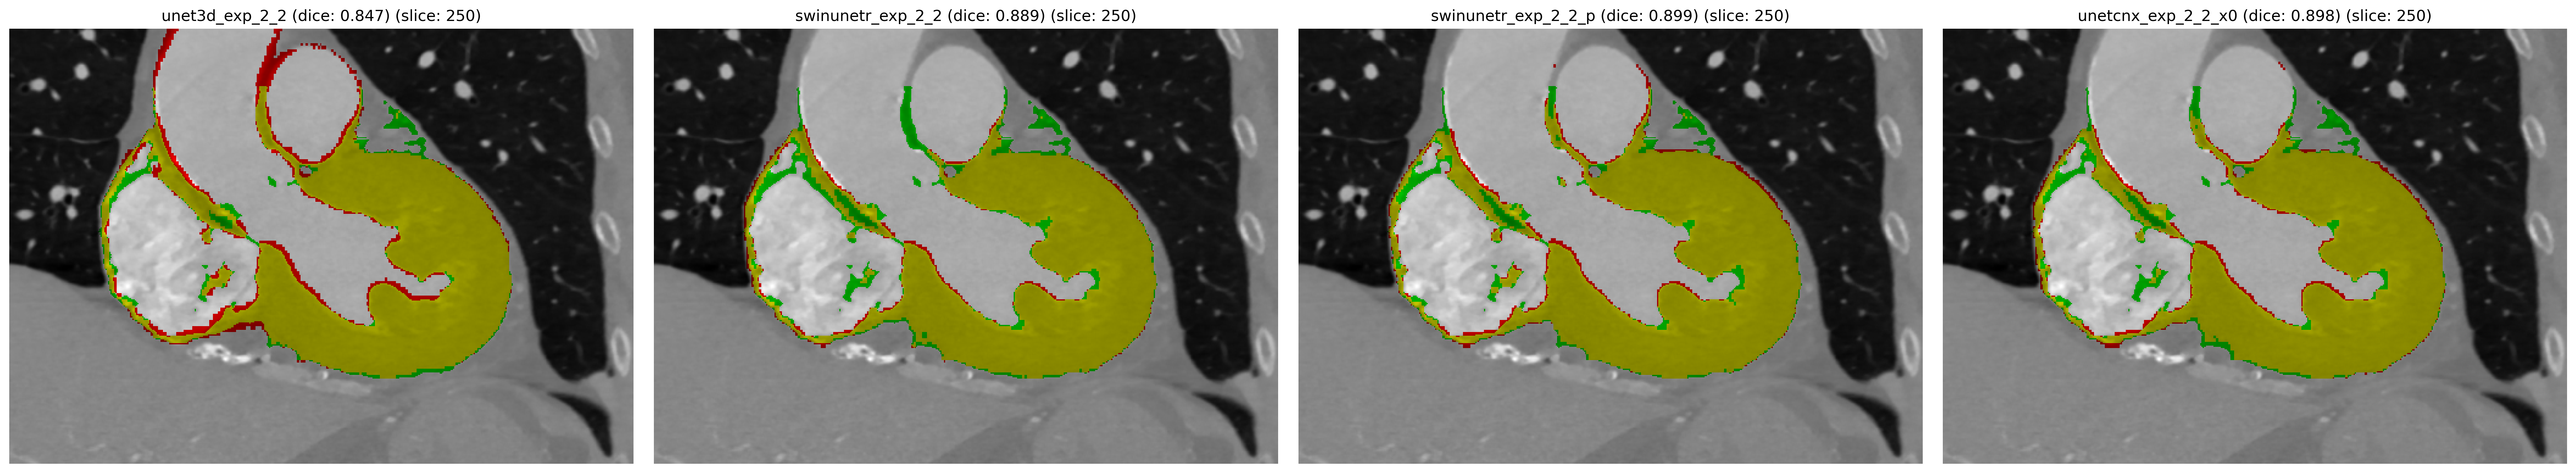

In [21]:
slice_idxs = [250] # [200,250,350]
fig_size = (num_img*7, len(slice_idxs)*5)

imgs, lbls, preds = get_img_lbl_preds(data, keys, slice_idxs, mode='c', is_trans=True)

#show_img_lbl_preds
show_img_lbl_preds_overlap(
    imgs,
    lbls,
    preds,
    pred_titles,
    slice_idxs,
    num_classes,
    axis_off,
    alpha,
    fig_size,
    show_img, 
    show_lbl_dc
)